

# 1. INTRODUCTION
<center>
<img src="https://img.freepik.com/free-photo/closeup-shot-wet-glass-reflecting-rainy-forest-scenery_181624-23365.jpg?t=st=1741439289~exp=1741442889~hmac=12d7248d3f9d2e6974e18bea8e694d97ef62a79c6d4983f2898152b18b74e3b7&w=2000" width=1300 height=800 />
</center>

# Rainfall Prediction Using Machine Learning

## Problem Statement

This project focuses on developing a machine learning model to predict rainfall based on meteorological data. The model aims to accurately forecast whether rain will occur on a given day, representing a binary classification problem where the target variable 'rainfall' is coded as 1 (rain) or 0 (no rain).

## Dataset Overview

The dataset contains various meteorological measurements recorded daily, including:

1. **Day**: Sequential identifier for each observation
2. **Pressure**: Atmospheric pressure measurement (in hPa)
3. **Maxtemp**: Maximum temperature for the day (in °C)
4. **Temperature**: Average temperature for the day (in °C)
5. **Mintemp**: Minimum temperature for the day (in °C)
6. **Dewpoint**: Dewpoint temperature (in °C)
7. **Humidity**: Relative humidity percentage
8. **Cloud**: Cloud cover percentage
9. **Sunshine**: Hours of sunshine
10. **Winddirection**: Wind direction (in degrees)
11. **Windspeed**: Wind speed (in km/h)
12. **Rainfall**: Target variable indicating whether rain occurred (1) or not (0)
13. **Original**: An additional identifier column

## Evaluation Metric

The model's performance will be evaluated using the **ROC-AUC** 

This evaluation approach is particularly suitable for binary classification problems and provides a comprehensive assessment of the model's ability to distinguish between rainy and non-rainy days across various probability thresholds. The ROC-AUC metric is especially valuable when dealing with potentially imbalanced class distributions in weather prediction scenarios.

In [1]:
# !pip install cmaes
# !pip install category_encoders
# !pip install -U imbalanced-learn
# !pip install torch
# !pip install pytorch-tabnet

import sklearn
import numpy as np
import os
import datetime,time
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
# !pip install sweetviz
# import sweetviz as sv
import concurrent.futures
from copy import deepcopy       
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
# !pip install yellowbrick
# from yellowbrick.cluster import KElbowVisualizer
# !pip install gap-stat
# from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
# !pip install optuna
import optuna

import cmaes
import xgboost as xgb
# !pip install catboost
# !pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb

from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier

from imblearn.ensemble import BalancedRandomForestClassifier
# from sklearn.datasets import make_classification
# from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LogisticRegressionCV
# from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


import tensorflow
import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, LeakyReLU, PReLU, ELU, Dropout

from keras.utils import to_categorical
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim

from concurrent.futures import ThreadPoolExecutor
from colorama import Fore, Style
from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None
pd.pandas.set_option('display.max_columns', None)

d:\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda3\envs\ML\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## 2.1 DATA

关键步骤说明：

1. 设备检测 ：优先使用GPU加速计算，提升模型训练速度
2. 数据清洗 ：统一温度特征列名（修正原始数据中的拼写错误 temparature → temperature ）
3. 特征工程 ：通过添加 original 标记列，后续可区分不同数据源的特征分布差异
4. 数据增强 ：将外部数据 Rainfall.csv 合并到训练集中，增加样本多样性
5. 数据保护 ：通过 copy() 创建数据副本，保留原始数据状态用于后续分析

In [2]:
# GPU设备检测
global device
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    device = 'gpu'  # 启用GPU加速
else:
    print("GPU is not available")
    device = 'cpu'  # 回退到CPU模式

# 数据加载与清洗
train=pd.read_csv('./train.csv').rename(columns={'temparature':'temperature'})  # 修正列名拼写错误
test=pd.read_csv('./test.csv').rename(columns={'temparature':'temperature'})
original=pd.read_csv("./Rainfall.csv").rename(columns={'temparature':'temperature'})
submission=pd.read_csv("./sample_submission.csv")

train.drop(columns=["id"],inplace=True)  # 删除无关ID列
test.drop(columns=["id"],inplace=True)
original['rainfall'] = original['rainfall'].map({'yes': 1, 'no': 0})  # 标签编码
original.columns=[f.strip() for f in original.columns]  # 去除列名空格

# 数据备份
train_copy=train.copy()  # 创建原始数据副本
test_copy=test.copy()
original_copy=original.copy()

# 数据源标记
original["original"]=1  # 标记原始数据集
train["original"]=0     # 标记比赛训练集
test["original"]=0      # 标记比赛测试集

# 数据合并
train=pd.concat([train,original],axis=0)  # 合并比赛数据与外部数据
train.reset_index(inplace=True,drop=True)  # 重置索引

# 目标变量设置
target='rainfall'  # 定义预测目标列

# 数据预览
train.head()  # 展示处理后的数据前五行

GPU is available


,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,original
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,0
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,0
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,0
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,0


## 2.2 Missing Value Check

主要注释说明：

1. 数据质量分析 ：该代码段用于生成数据集特征的全面质量报告
2. 缺失率计算 ： 100 - (非空计数/总行数)*100 的公式计算缺失值比例
3. 离散值比例 ：通过唯一值数量占比判断特征的离散程度（>0.5可能为类别型特征）
4. 特殊处理 ：对目标列 rainfall 在测试集的缺失率标记为"NA"
5. 多数据集对比 ：同时分析训练集、测试集和原始数据集的缺失情况
6. 结果应用 ：输出结果可用于指导后续的缺失值处理、特征工程和模型选择
输出表格各列含义：

- Discrete Ratio (Train) ：值越接近1表示特征越接近唯一值（如ID列），接近0表示重复值多（如类别型特征）

In [3]:
# 创建PrettyTable对象用于美观地展示表格数据
table = PrettyTable()
# 定义表格列名：特征名、数据类型、训练集缺失率、测试集缺失率、原始数据缺失率、离散值比例
table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %', "Original Missing%", "Discrete Ratio (Train)"]

# 遍历训练数据集的所有列（特征）
for column in train_copy.columns:
    # 获取当前列的数据类型（字符串格式）
    data_type = str(train_copy[column].dtype)
    
    # 计算训练集缺失百分比 = (总行数 - 非空行数)/总行数 * 100，保留1位小数
    non_null_count_train = np.round(100 - train_copy[column].count()/train_copy.shape[0]*100, 1)
    
    # 处理测试集缺失率（目标列没有测试集数据）
    if column != target:
        # 计算测试集缺失百分比（同上）
        non_null_count_test = np.round(100 - test_copy[column].count()/test_copy.shape[0]*100, 1)
    else:
        non_null_count_test = "NA"  # 目标列在测试集中不存在
    
    # 计算原始数据集缺失百分比（同上）
    non_null_count_orig = np.round(100 - original_copy[column].count()/original_copy.shape[0]*100, 1)
    
    # 计算离散值比例 = 唯一值数量 / 总样本数（保留4位小数）
    # 用于判断特征是否是类别型或高基数特征
    discrete_ratio = np.round(train_copy[column].nunique() / train_copy.shape[0], 4)
    
    # 将计算结果添加到表格行中
    table.add_row([column, data_type, non_null_count_train, non_null_count_test, non_null_count_orig, discrete_ratio])

# 打印完整的数据质量分析表格
print(table)

+---------------+-----------+-----------------+----------------+-------------------+------------------------+
|    Feature    | Data Type | Train Missing % | Test Missing % | Original Missing% | Discrete Ratio (Train) |
+---------------+-----------+-----------------+----------------+-------------------+------------------------+
|      day      |   int64   |       0.0       |      0.0       |        0.0        |         0.1667         |
|    pressure   |  float64  |       0.0       |      0.0       |        0.0        |         0.1078         |
|    maxtemp    |  float64  |       0.0       |      0.0       |        0.0        |          0.1           |
|  temperature  |  float64  |       0.0       |      0.0       |        0.0        |         0.0904         |
|    mintemp    |  float64  |       0.0       |      0.0       |        0.0        |         0.0909         |
|    dewpoint   |  float64  |       0.0       |      0.0       |        0.0        |         0.0995         |
|    humid

<font size="3">Few Missing Values winddirection, windspeed</font>

# 3. EXPLORATORY DATA ANALYSIS

## 3.1 Target Distributions

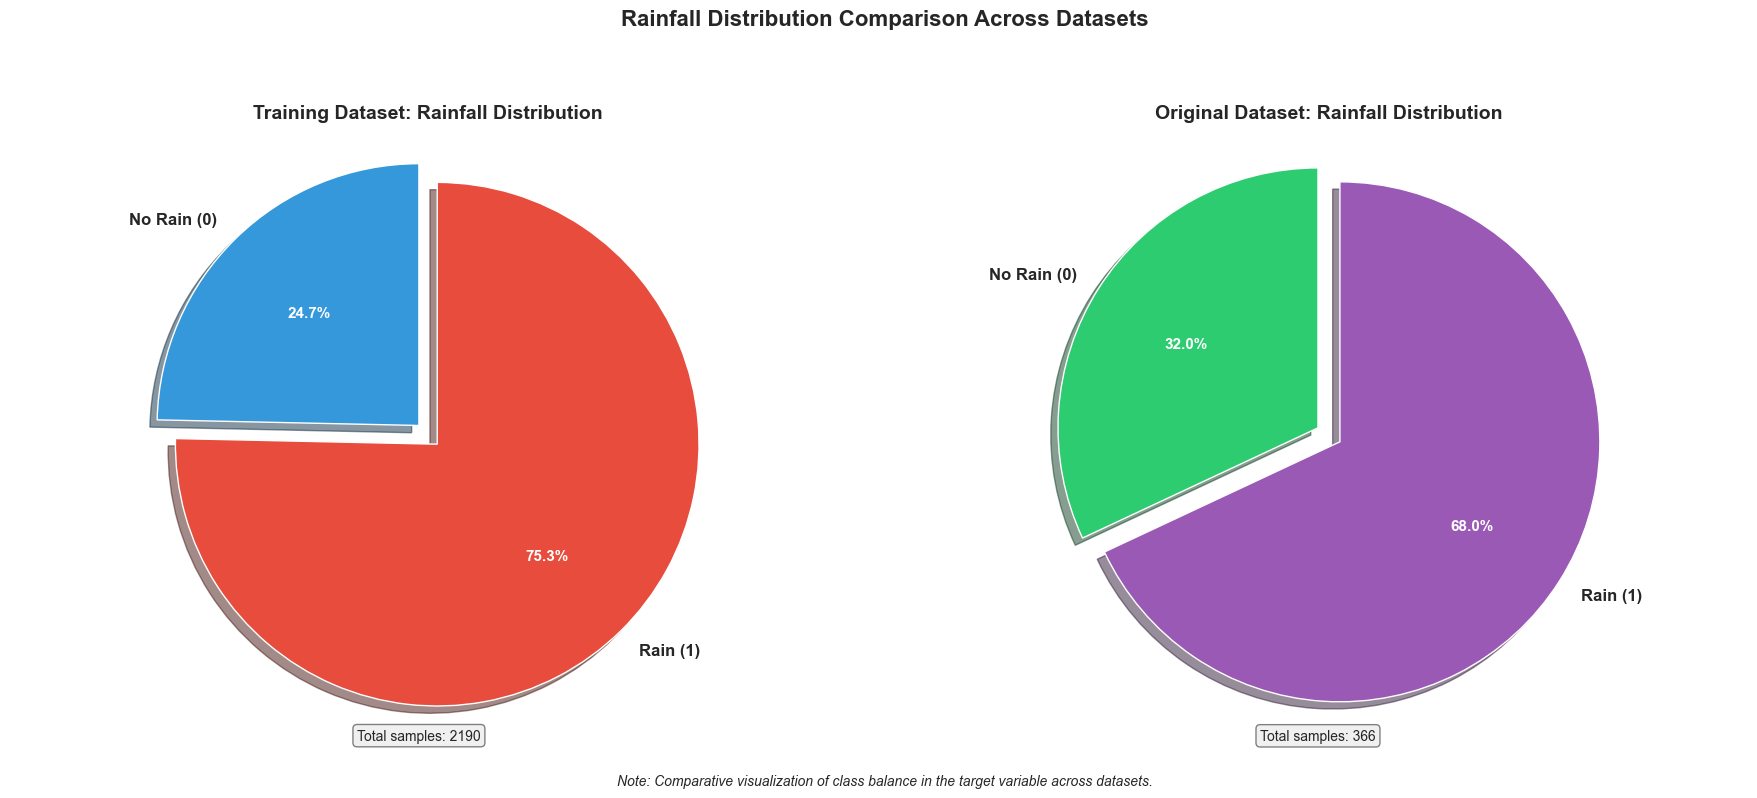

In [6]:
def plot_rainfall_distribution(data, title, ax, colors=None, shadow=True, startangle=90):
    """
    生成增强型降雨分布饼图，支持自定义样式和布局
    
    参数说明：
        data (DataFrame): 包含目标变量的数据集
        title (str):     图表标题
        ax (axes):      绘图坐标轴对象
        colors (list):  自定义颜色列表（可选）
        shadow (bool):  是否显示阴影（默认True）
        startangle (int): 饼图起始角度（默认90度）
    """
    # 统计目标变量分布
    data_counts = data[target].value_counts().sort_index()
    
    # 定义分类标签（0:无雨，1:有雨）
    labels = ['No Rain (0)', 'Rain (1)']  # 恢复英文标签
    
    # 获取对应分类的样本数量
    sizes = [data_counts.get(0, 0), data_counts.get(1, 0)]
    
    # 设置默认颜色（蓝色表示无雨，红色表示有雨）
    if colors is None:
        colors = ['#3498db', '#e74c3c']
    
    # 设置饼图突出效果（突出显示有雨的部分）
    explode = (0, 0.1)

    # 绘制饼图核心参数
    wedges, texts, autotexts = ax.pie(
        sizes,
        explode=explode, 
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        shadow=shadow,
        startangle=startangle,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1}
    )
    
    # 定制标签文本样式
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    
    # 定制百分比文本样式
    for autotext in autotexts:
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
        autotext.set_color('white')
    
    # 添加数据集样本量标注
    ax.text(
        0, -1.2,
        f"Total samples: {len(data)}",  
        ha='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc='#f0f0f0', ec='gray')
    )
    
    # 确保饼图为正圆形
    ax.axis('equal')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

# 创建画布和子图（1行2列布局）
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 定义色盲友好配色方案
custom_colors = [
    ['#3498db', '#e74c3c'],  # 蓝红组合（训练集）
    ['#2ecc71', '#9b59b6']   # 绿紫组合（原始数据集）
]

# 绘制训练数据集分布
plot_rainfall_distribution(train_copy, "Training Dataset: Rainfall Distribution", axes[0], colors=custom_colors[0])
plot_rainfall_distribution(original, "Original Dataset: Rainfall Distribution", axes[1], colors=custom_colors[1])

# 添加主标题
fig.suptitle('Rainfall Distribution Comparison Across Datasets', fontsize=16, fontweight='bold', y=0.98)  

# 添加图表脚注说明
footnote = "Note: Comparative visualization of class balance in the target variable across datasets."  
plt.figtext(0.5, 0.01, footnote, ha='center', fontsize=10, style='italic')

# 调整子图间距防止重叠
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 3.2 Numerical Feature Distributions

代码核心功能说明：

1. 可视化对比 ：通过并排的小提琴图，对比训练集和原始数据集中每个连续特征在降雨/无雨状态下的分布差异
2. 分布呈现 ：小提琴图结合了核密度估计和箱线图特性，能同时展示数据分布形状和统计量
3. 样式优化 ：
   - 使用专业配色方案（蓝/红）增强可读性
   - 添加横向虚线网格辅助数据解读
   - 统一字体大小和样式保持视觉一致性
4. 自动化布局 ：
   - 根据特征数量自动计算画布高度
   - 智能处理单个特征的边界情况
   - 动态调整子图间距防止重叠
5. 统计信息展示 ：
   - inner='quartile'显示四分位线
   - cut=0保证完整数据范围显示
   - 线宽调整增强图表可读性

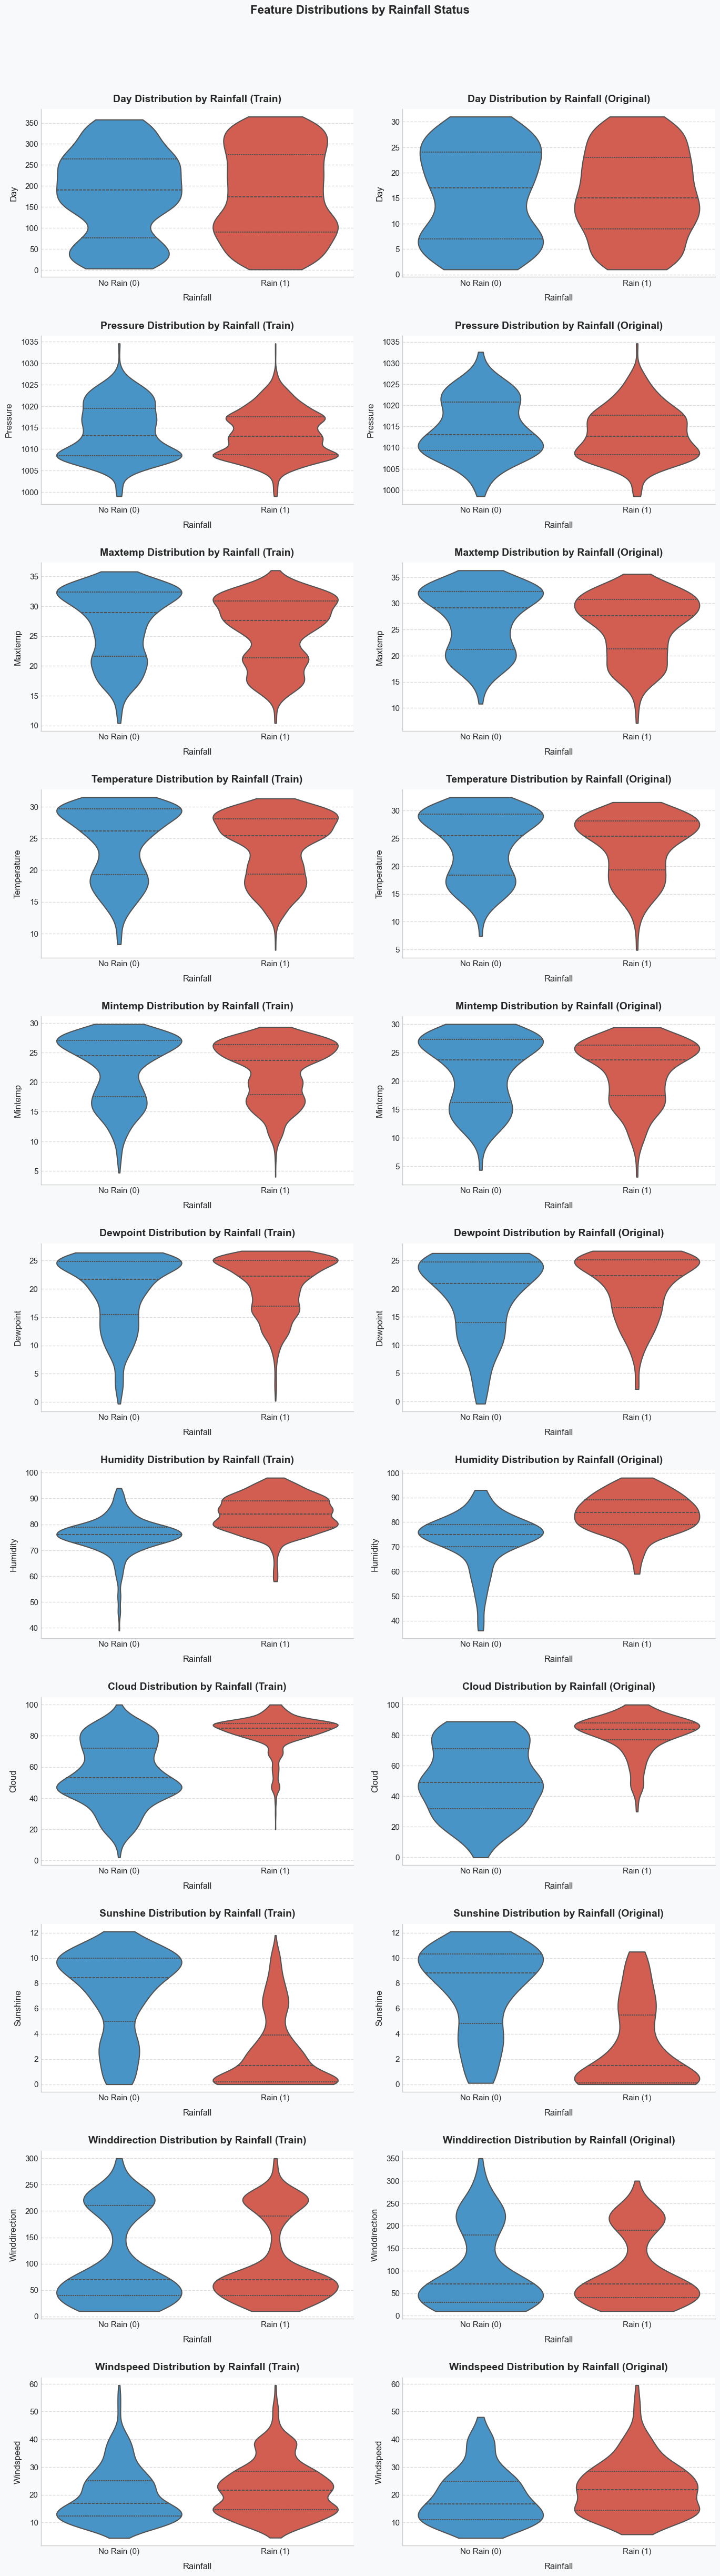

In [7]:
# 定义专业配色方案（蓝色代表无雨，红色代表有雨）
custom_palette = ["#3498db", "#e74c3c"]

# 配置全局绘图样式
plt.style.use('seaborn-v0_8-whitegrid')  # 使用带网格线的白底样式
plt.rcParams['font.family'] = 'sans-serif'  # 设置通用字体类型
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']  # 备选无衬线字体

# 获取连续型特征列表（排除对象类型且唯一值大于2的特征）
cont_cols = [f for f in train.columns if train[f].dtype != 'O' and train[f].nunique()>2]
n_rows = len(cont_cols)  # 确定需要绘制的行数（每个特征一行）

# 创建自定义尺寸的画布（每行高度4.5英寸，DPI分辨率100）
fig, axs = plt.subplots(n_rows, 2, figsize=(14, 4.5 * n_rows), dpi=100)

# 确保axs始终为二维数组（处理单个特征的边界情况）
if n_rows == 1:
    axs = np.array([axs])

# 设置画布背景颜色（浅灰色）
fig.patch.set_facecolor('#f8f9fa')

# 循环绘制每个连续特征的小提琴图
for i, col in enumerate(cont_cols):
    # ----------------- 训练集子图 -----------------
    # 绘制左侧训练集分布图
    sns.violinplot(
        x=target, 
        y=col, 
        data=train_copy, 
        ax=axs[i, 0],
        palette=custom_palette,
        inner='quartile',  # 显示四分位线
        linewidth=1.5,     # 调整线条粗细
        cut=0              # 显示完整数据范围
    )
    # 设置训练集子图样式
    axs[i, 0].set_title(f'{col.title()} Distribution by Rainfall (Train)', 
                       fontsize=14, fontweight='bold', pad=10)
    axs[i, 0].set_xlabel('Rainfall', fontsize=12, labelpad=10)
    axs[i, 0].set_ylabel(col.title(), fontsize=12, labelpad=10)
    axs[i, 0].tick_params(labelsize=11)  # 调整刻度标签大小
    axs[i, 0].grid(axis='y', linestyle='--', alpha=0.7)  # 添加横向虚线网格
    
    # ----------------- 原始数据集子图 -----------------
    # 绘制右侧原始数据分布图
    sns.violinplot(
        x=target, 
        y=col, 
        data=original, 
        ax=axs[i, 1],
        palette=custom_palette,
        inner='quartile',
        linewidth=1.5,
        cut=0
    )
    # 设置原始数据集子图样式
    axs[i, 1].set_title(f'{col.title()} Distribution by Rainfall (Original)', 
                       fontsize=14, fontweight='bold', pad=10)
    axs[i, 1].set_xlabel('Rainfall', fontsize=12, labelpad=10)
    axs[i, 1].set_ylabel(col.title(), fontsize=12, labelpad=10)
    axs[i, 1].tick_params(labelsize=11)
    axs[i, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # ----------------- 通用设置 -----------------
    # 统一设置x轴标签（两个子图）
    for j in range(2):
        axs[i, j].set_xticklabels(['No Rain (0)', 'Rain (1)'])  # 明确分类标签
    
    # 移除多余边框线（保留左侧和底部）
    sns.despine(ax=axs[i, 0])
    sns.despine(ax=axs[i, 1])

# 添加全局标题（位于顶部0.99位置）
fig.suptitle('Feature Distributions by Rainfall Status', 
            fontsize=16, fontweight='bold', y=0.99)

# 优化布局参数
fig.tight_layout(rect=[0, 0, 1, 0.97])  # 调整子图区域范围
plt.subplots_adjust(hspace=0.35)       # 设置行间距为35%
plt.show()

# 4. FEATURE ENGINEERING

## Utility 

In [ ]:
def min_max_scaler(train, test, column):
    '''
    鲁棒型最小最大归一化方法（跨数据集）
    
    参数：
        train (DataFrame): 训练数据集
        test (DataFrame):  测试数据集
        column (str):      需要归一化的特征名称
    
    特点：
        - 跨数据集计算最大最小值，防止测试集出现越界值
        - 避免传统方法中仅用训练集统计量导致的测试集溢出问题
    '''
    sc = MinMaxScaler()
    
    # 获取全局最大最小值（考虑训练集和测试集的分布）
    max_val = max(train[column].max(), test[column].max())
    min_val = min(train[column].min(), test[column].min())

    # 执行归一化计算（公式：(x - min)/(max - min)）
    train[column] = (train[column] - min_val) / (max_val - min_val)
    test[column] = (test[column] - min_val) / (max_val - min_val)
    
    return train, test  

def OHE(train_df, test_df, cols, target):
    '''
    增强型独热编码方法（带冗余类别处理）
    
    参数：
        train_df (DataFrame): 训练数据
        test_df (DataFrame):  测试数据
        cols (list):         需要编码的分类特征列表
        target (str):        目标变量名称
    
    特点：
        - 合并数据集进行编码，避免类别缺失问题
        - 自动删除频率最低的类别（减少维度+避免过拟合）
        - 防止测试集出现训练集未包含的类别
    '''
    # 合并数据集（确保编码完整性）
    combined = pd.concat([train_df, test_df], axis=0)
    
    for col in cols:
        # 生成独热编码矩阵
        one_hot = pd.get_dummies(combined[col])
        
        # 识别并删除最少出现的类别（基于频次统计）
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        
        # 重命名列（添加特征后缀避免冲突）
        one_hot.columns = [str(f) + col + "_OHE" for f in one_hot.columns]
        
        # 合并编码结果并去重
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    # 数据集拆分与后处理
    train_ohe = combined[:len(train_df)]          # 还原训练集
    test_ohe = combined[len(train_df):]           # 提取测试集
    test_ohe.reset_index(inplace=True, drop=True) # 重置索引
    
    # 移除测试集中的目标变量（如果存在）
    if target in test_ohe.columns:
        test_ohe.drop(columns=[target], inplace=True)
        
    return train_ohe, test_ohe

## 4.1 Impute Missing Values

In [9]:
def handle_missing_values(train_df, test_df, target="rainfall", n_components=1):
    """
    处理包含缺失值的数值型数据集，主要步骤包括：
    1. 使用中位数进行缺失值填补
    2. 创建缺失值指示器
    3. 应用SVD降维合并指示器列
    
    参数：
    -----------
    train_df : pandas DataFrame
        包含缺失值的训练数据集（仅数值型）
    test_df : pandas DataFrame
        包含缺失值的测试数据集（仅数值型）
    target : str, default="rainfall"
        目标变量名称（将排除在填补和处理之外）
    n_components : int, default=1
        SVD后保留的主成分数量
        
    返回：
    --------
    train_processed : pandas DataFrame
        处理后的训练数据，包含填补值和SVD特征
    test_processed : pandas DataFrame
        处理后的测试数据，包含填补值和SVD特征
    """
    # 创建副本以避免修改原始数据集
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    
    # 处理目标列
    y_train = None
    if target in train_df.columns:
        y_train = train_processed[target].copy()
        train_processed = train_processed.drop(columns=[target])
    
    # 获取特征列（排除目标变量）
    train_features = train_processed.columns.tolist()
    
    # 获取训练集和测试集的共同特征
    common_features = [col for col in train_features if col in test_df.columns]
    
    # 仅使用共同特征进行填补以确保一致性
    train_subset = train_processed[common_features]
    test_subset = test_processed[common_features]
    
    # 步骤1：填补 - 创建数值型列的简单填补器
    numeric_imputer = SimpleImputer(strategy='median')
    
    # 仅在共同特征上拟合填补器
    numeric_imputer.fit(train_subset)
    
    # 转换两个数据集
    train_imputed_values = numeric_imputer.transform(train_subset)
    test_imputed_values = numeric_imputer.transform(test_subset)
    
    # 从填补值创建DataFrame
    train_imputed = pd.DataFrame(
        train_imputed_values,
        columns=common_features,
        index=train_processed.index
    )
    
    test_imputed = pd.DataFrame(
        test_imputed_values,
        columns=common_features,
        index=test_processed.index
    )
    
    # 将非共同特征添加回训练集（不进行填补）
    non_common_features = [col for col in train_features if col not in common_features]
    for col in non_common_features:
        train_imputed[col] = train_processed[col]
    
    # 步骤2：为共同特征创建缺失值指示器
    indicator_cols = []
    for col in common_features:
        indicator_name = f'{col}_missing'
        train_imputed[indicator_name] = train_df[col].isna().astype(int)
        test_imputed[indicator_name] = test_df[col].isna().astype(int)
        indicator_cols.append(indicator_name)
    
    # 步骤3：应用SVD将指示器列合并到更少的维度
    if indicator_cols and len(indicator_cols) > 1:  # 仅在存在多个指示器时应用SVD
        # 使用指定数量的主成分初始化SVD
        svd = TruncatedSVD(n_components=min(n_components, len(indicator_cols)))
        
        # 在训练数据指示器上拟合SVD并转换两个数据集
        missing_indicators_train = train_imputed[indicator_cols].values
        missing_indicators_test = test_imputed[indicator_cols].values
        
        # 仅在存在缺失值时进行SVD
        if np.any(missing_indicators_train):
            # 拟合和转换
            missing_svd_train = svd.fit_transform(missing_indicators_train)
            missing_svd_test = svd.transform(missing_indicators_test)
            
            # 将SVD组件添加到数据集中
            for i in range(n_components):
                train_imputed[f'missing_svd_{i}'] = missing_svd_train[:, i]
                test_imputed[f'missing_svd_{i}'] = missing_svd_test[:, i]
            
            # 可选地删除原始指示器列（如果不再需要）
            train_imputed.drop(columns=indicator_cols, inplace=True)
            test_imputed.drop(columns=indicator_cols, inplace=True)
    
    # 如果存在目标列，将其添加回训练数据
    if y_train is not None:
        train_imputed[target] = y_train
    
    return train_imputed, test_imputed
    
train_imputed, test_imputed = handle_missing_values(train, test, n_components=1)

## 4.2 Derived Features

创建了6大类共42+个特征

In [10]:
def engineer_features(df):
    """
    气象特征工程函数（防数据泄漏版）
    
    基于气象学原理和数据分析创建新特征，主要特点：
    - 使用'day'表示一年中的第几天（1-365）
    - 所有特征仅使用当日及历史数据生成
    - 严格避免使用目标变量（rainfall）
    
    参数：
        df (DataFrame): 原始气象数据（需包含基础气象指标）
    
    返回：
        enhanced_df (DataFrame): 包含42+新特征的数据框
    """
    # 创建副本避免污染原始数据
    enhanced_df = df.copy()
    
    # ================= 基础衍生特征 =================
    # 1. 温度范围（昼夜温差）
    enhanced_df['temp_range'] = enhanced_df['maxtemp'] - enhanced_df['mintemp']
    
    # 2. 露点差（气温与露点温差，反映空气饱和程度）
    enhanced_df['dewpoint_depression'] = enhanced_df['temperature'] - enhanced_df['dewpoint']
    
    # 3. 气压日变化（与前日差值，反映气压系统移动）
    enhanced_df['pressure_change'] = enhanced_df['pressure'].diff().fillna(0)
    
    # ================= 比值类特征 =================
    # 4. 湿度露点比（clip防止除以0）
    enhanced_df['humidity_dewpoint_ratio'] = enhanced_df['humidity'] / enhanced_df['dewpoint'].clip(lower=0.1)
    
    # 5. 云量日照比（反映云层对日照的遮挡效应）
    enhanced_df['cloud_sunshine_ratio'] = enhanced_df['cloud'] / enhanced_df['sunshine'].clip(lower=0.1)
    
    # 6. 风-湿度综合因子（风速与相对湿度的相互作用）
    enhanced_df['wind_humidity_factor'] = enhanced_df['windspeed'] * (enhanced_df['humidity'] / 100)
    
    # ================= 复合气象指数 =================
    # 7. 温湿指数（简化版体感温度公式）
    enhanced_df['temp_humidity_index'] = (0.8 * enhanced_df['temperature']) + \
                                        ((enhanced_df['humidity'] / 100) * \
                                        (enhanced_df['temperature'] - 14.3)) + 46.4
    
    # 8. 气压变化加速度（二阶差分）
    enhanced_df['pressure_acceleration'] = enhanced_df['pressure_change'].diff().fillna(0)
    
    # ================= 时间维度特征 =================
    # 9. 月份特征（每30天为一个月，上限12月）
    enhanced_df['month'] = ((enhanced_df['day'] - 1) // 30) + 1
    enhanced_df['month'] = enhanced_df['month'].clip(upper=12)
    
    # 10. 季节特征（每3个月为一个季节）
    enhanced_df['season'] = ((enhanced_df['month'] - 1) // 3) + 1
    
    # 11. 日期周期性编码（捕捉年周期规律）
    enhanced_df['day_of_year_sin'] = np.sin(2 * np.pi * enhanced_df['day'] / 365)
    enhanced_df['day_of_year_cos'] = np.cos(2 * np.pi * enhanced_df['day'] / 365)
    
    # ================= 滑动窗口特征 =================
    # 12. 关键指标滑动平均（3/7/14天窗口）
    for window in [3, 7, 14]:
        # 温度滑动平均（至少需要1个观测值）
        enhanced_df[f'temperature_rolling_{window}d'] = enhanced_df['temperature'].rolling(window=window, min_periods=1).mean()
        # 气压滑动平均
        enhanced_df[f'pressure_rolling_{window}d'] = enhanced_df['pressure'].rolling(window=window, min_periods=1).mean()
        # 湿度滑动平均
        enhanced_df[f'humidity_rolling_{window}d'] = enhanced_df['humidity'].rolling(window=window, min_periods=1).mean()
        # 云量滑动平均
        enhanced_df[f'cloud_rolling_{window}d'] = enhanced_df['cloud'].rolling(window=window, min_periods=1).mean()
        # 风速滑动平均
        enhanced_df[f'windspeed_rolling_{window}d'] = enhanced_df['windspeed'].rolling(window=window, min_periods=1).mean()
    
    # ================= 趋势特征 =================
    # 13. 三日趋势（当前值与3天前差值）
    enhanced_df['temp_trend_3d'] = enhanced_df['temperature'].diff(3).fillna(0)  # 温度趋势
    enhanced_df['pressure_trend_3d'] = enhanced_df['pressure'].diff(3).fillna(0)  # 气压趋势
    enhanced_df['humidity_trend_3d'] = enhanced_df['humidity'].diff(3).fillna(0)  # 湿度趋势
    
    # ================= 极端事件指标 =================
    # 14. 温度极端值（超出5%和95%分位数）
    enhanced_df['extreme_temp'] = (enhanced_df['temperature'] > enhanced_df['temperature'].quantile(0.95)) | \
                                 (enhanced_df['temperature'] < enhanced_df['temperature'].quantile(0.05))
    enhanced_df['extreme_temp'] = enhanced_df['extreme_temp'].astype(int)
    
    # 湿度极端值
    enhanced_df['extreme_humidity'] = (enhanced_df['humidity'] > enhanced_df['humidity'].quantile(0.95)) | \
                                     (enhanced_df['humidity'] < enhanced_df['humidity'].quantile(0.05))
    enhanced_df['extreme_humidity'] = enhanced_df['extreme_humidity'].astype(int)
    
    # 气压极端值 
    enhanced_df['extreme_pressure'] = (enhanced_df['pressure'] > enhanced_df['pressure'].quantile(0.95)) | \
                                     (enhanced_df['pressure'] < enhanced_df['pressure'].quantile(0.05))
    enhanced_df['extreme_pressure'] = enhanced_df['extreme_pressure'].astype(int)
    
    # ================= 交互特征 =================
    # 15. 关键变量交互项（捕捉非线性关系）
    enhanced_df['temp_humidity_interaction'] = enhanced_df['temperature'] * enhanced_df['humidity']  # 温湿交互
    enhanced_df['pressure_wind_interaction'] = enhanced_df['pressure'] * enhanced_df['windspeed']  # 气压风速交互
    enhanced_df['cloud_sunshine_interaction'] = enhanced_df['cloud'] * enhanced_df['sunshine']  # 云量日照交互
    enhanced_df['dewpoint_humidity_interaction'] = enhanced_df['dewpoint'] * enhanced_df['humidity']  # 露点湿度交互
    
    # ================= 波动性特征 =================
    # 16. 滑动标准差（7/14天窗口，至少4个观测值）
    for window in [7, 14]:
        # 温度波动性
        enhanced_df[f'temp_std_{window}d'] = enhanced_df['temperature'].rolling(window=window, min_periods=4).std().fillna(0)
        # 气压波动性
        enhanced_df[f'pressure_std_{window}d'] = enhanced_df['pressure'].rolling(window=window, min_periods=4).std().fillna(0)
        # 湿度波动性
        enhanced_df[f'humidity_std_{window}d'] = enhanced_df['humidity'].rolling(window=window, min_periods=4).std().fillna(0)
    
    return enhanced_df
    
# 应用特征工程（训练集和测试集独立处理，避免数据泄漏）
train_fe = engineer_features(train_imputed)
test_fe = engineer_features(test_imputed)

# 5. FEATURE SELECTION

In [11]:
# ===================== 特征选择与预处理 ===================== #
# 生成最终特征列表（排除目标变量）
final_features = [f for f in train_fe.columns if f not in [target]]
# 使用集合去重（防止特征重复）
final_features = [*set(final_features)]

# 初始化标准化器（Z-score标准化）
# 使用StandardScaler保证训练集/测试集使用相同的缩放参数
sc = StandardScaler()

# 创建数据副本以避免污染原始特征工程数据
train_scaled = train_fe.copy()  # 训练集副本
test_scaled = test_fe.copy()    # 测试集副本

# 对数值型特征进行标准化处理
# 训练集：拟合缩放器并转换数据（fit_transform）
# 测试集：仅使用训练集的参数进行转换（transform）
train_scaled[final_features] = sc.fit_transform(train_fe[final_features])
test_scaled[final_features] = sc.transform(test_fe[final_features])

In [12]:
def post_processor(train, test):
    """
    后处理函数：检测并删除高度相关的重复特征
    
    功能：
    1. 识别训练集中完全相同的特征列
    2. 在训练集和测试集中同步删除重复特征
    3. 维护特征一致性，避免数据泄露
    
    参数：
        train (DataFrame): 处理后的训练数据集
        test (DataFrame): 处理后的测试数据集
    
    返回：
        train_cop, test_cop: 删除重复列后的数据集副本
    """
    # 获取除目标变量外的所有特征列
    cols = train.drop(columns=[target]).columns
    
    # 创建数据副本（避免修改原始数据）
    train_cop = train.copy()  # 训练集副本
    test_cop = test.copy()    # 测试集副本
    
    # 初始化待删除列列表
    drop_cols = []
    
    # 双重循环遍历所有特征组合（O(n²)时间复杂度）
    for i, feature in enumerate(cols):
        # 比较当前特征与后续所有特征
        for j in range(i+1, len(cols)):
            # 计算两列绝对差异之和（若为0表示完全相同）
            if sum(abs(train_cop[feature] - train_cop[cols[j]])) == 0:
                # 将重复列加入删除列表（保留先出现的特征）
                if cols[j] not in drop_cols:
                    drop_cols.append(cols[j])
    
    print("重复特征列：", drop_cols)  # 打印被删除的特征
    
    # 同步删除训练集和测试集中的重复列
    train_cop.drop(columns=drop_cols, inplace=True)  # 就地修改训练集副本
    test_cop.drop(columns=drop_cols, inplace=True)  # 测试集保持相同操作
    
    return train_cop, test_cop

# ================ 函数调用与数据分割 ================ #
# 应用后处理函数（输入标准化后的数据）
train_cop, test_cop = post_processor(train_scaled, test_scaled)

# 特征矩阵与目标变量分离
X_train = train_cop.drop(columns=[target])  # 训练特征矩阵
y_train = train[target]                    # 训练目标变量（使用原始数据的目标列）

X_test = test_cop.copy()  # 测试集特征矩阵（不含目标变量）

# 输出处理后的数据维度
print("最终维度：", X_train.shape, X_test.shape)

重复特征列： []
最终维度： (2556, 56) (730, 56)


In [ ]:
def get_most_important_features(X_train, y_train, n, model_input):
    """
    交叉验证特征重要性分析函数
    
    功能：
    1. 根据输入模型类型自动配置参数（XGBoost/LightGBM/CatBoost）
    2. 5折交叉验证训练模型并收集特征重要性
    3. 可视化Top10特征重要性并显示平均AUC
    4. 返回前N个重要特征列表
    
    参数：
        X_train (DataFrame): 训练特征矩阵
        y_train (Series): 训练目标变量
        n (int): 需要返回的重要特征数量
        model_input (str): 模型标识符（包含'xgb'/'cat'则使用对应模型，默认LightGBM）
    
    返回：
        top_n_features (list): 前N个重要特征名称列表
    """
    # ================= 模型参数配置 =================
    # XGBoost参数配置（根据设备类型自动启用GPU加速）
    xgb_params = {
        'n_jobs': -1,  # 使用全部CPU核心
        'eval_metric': 'logloss',  # 评估指标
        'objective': 'binary:logistic',  # 二分类任务
        'tree_method': 'hist',  # 默认使用直方图算法
        'verbosity': 0,  # 关闭训练日志
        'random_state': 42,  # 随机种子
    }
    if device == 'gpu':
        xgb_params.update({
            'tree_method': 'gpu_hist',  # GPU加速的直方图算法
            'predictor': 'gpu_predictor'  # GPU预测
        })

    # LightGBM参数配置
    lgb_params = {
        'objective': 'binary',  # 二分类任务
        'metric': 'logloss',  # 评估指标
        'boosting_type': 'gbdt',  # 梯度提升树
        'random_state': 42,
        'device': device,  # 自动选择计算设备
        'verbose': -1  # 完全关闭训练输出
    }

    # CatBoost参数配置
    cb_params = {
        'grow_policy': 'Depthwise',  # 深度优先生长策略
        'bootstrap_type': 'Bayesian',  # 贝叶斯自助采样
        'od_type': 'Iter',  # 过拟合检测类型
        'eval_metric': 'AUC',  # 评估指标
        'loss_function': 'Logloss',  # 损失函数
        'random_state': 42,
        'task_type': device.upper(),  # 设备类型大写转换
    }

    # ================= 模型选择器 =================
    if 'xgb' in model_input:
        model = xgb.XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model = CatBoostClassifier(**cb_params)
    else:
        model = lgb.LGBMClassifier(**lgb_params)

    # ================= 交叉验证框架 =================
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []  # 存储各fold的AUC得分
    feature_importances_list = []  # 存储各fold的特征重要性

    # ================= 交叉验证循环 =================
    for train_idx, val_idx in kfold.split(X_train):
        # 数据划分（保持原始索引）
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # 模型训练（LightGBM需要保留进度条输出）
        if "lgb" not in model_input:
            model.fit(X_train_fold, y_train_fold, verbose=False)  # 非LGBM模型关闭训练日志
        else:
            model.fit(X_train_fold, y_train_fold)  # LGBM使用内置进度条

        # 预测与评估
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        auc_scores.append(roc_auc_score(y_val_fold, y_pred))
        
        # 收集特征重要性（不同模型的特征重要性自动对齐）
        feature_importances_list.append(model.feature_importances_)

    # ================= 结果聚合 =================
    avg_auc = np.mean(auc_scores)  # 平均AUC得分
    avg_feature_importances = np.mean(feature_importances_list, axis=0)  # 平均特征重要性

    # ================= 特征排序 =================
    # 创建（特征名，重要性）元组列表
    feature_importance_list = [(X_train.columns[i], imp) 
                              for i, imp in enumerate(avg_feature_importances)]
    # 按重要性降序排序
    sorted_features = sorted(feature_importance_list, 
                            key=lambda x: x[1], 
                            reverse=True)
    # 提取前N个特征名称
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    # ================= 可视化模块 =================
    display_features = top_n_features[:10]  # 仅展示前10个特征
    importance_values = [avg_feature_importances[X_train.columns.get_loc(f)] for f in display_features]

    # 创建颜色渐变（从浅红到深红）
    colors = plt.cm.YlOrRd(np.linspace(1, 0.3, len(display_features)))

    plt.figure(figsize=(10, 8))
    bars = plt.barh(range(len(display_features)), 
                importance_values, 
                color=colors,
                edgecolor='black',
                alpha=0.8)

    # 图表装饰
    plt.yticks(range(len(display_features)), display_features, fontsize=14)
    plt.xticks(fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14, labelpad=15)
    plt.ylabel('Features', fontsize=14, labelpad=15)
    plt.title(f'Top {10} of {n} Feature Importances with ROC AUC score {avg_auc:.4f}', fontsize=16, pad=20, fontweight='bold')
    plt.gca().invert_yaxis()  # 倒置Y轴使最重要特征在上方
    # 添加网格线
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # 添加数据标签
    for idx, value in enumerate([avg_feature_importances[X_train.columns.get_loc(f)] 
                                for f in display_features]):
        plt.text(value + 0.005, idx, f'{value:.3f}', fontsize=12, va='center')
    
    plt.tight_layout()
    plt.show()

    return top_n_features

分别使用CatBoost、XGBoost和LightGBM模型来获取最重要的50个特征

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


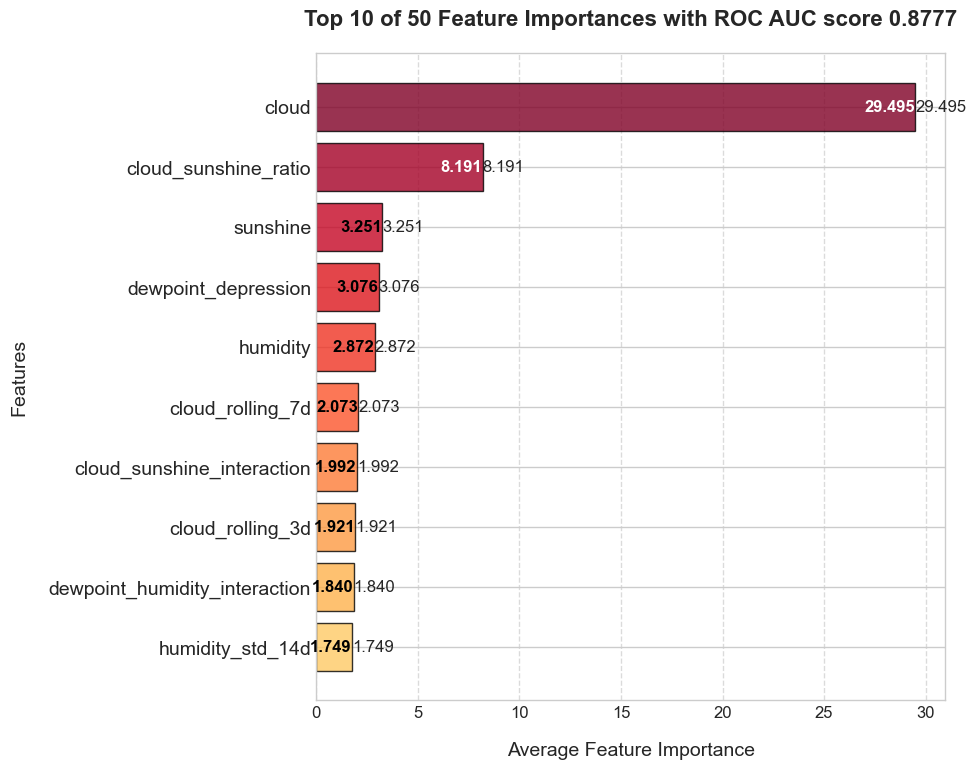

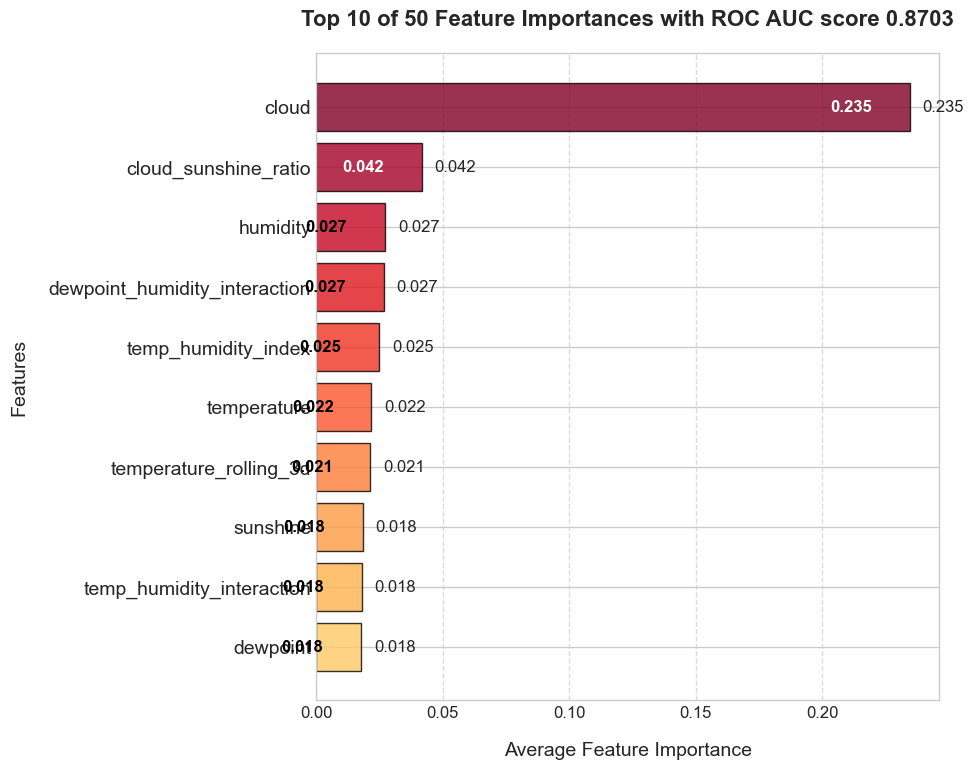

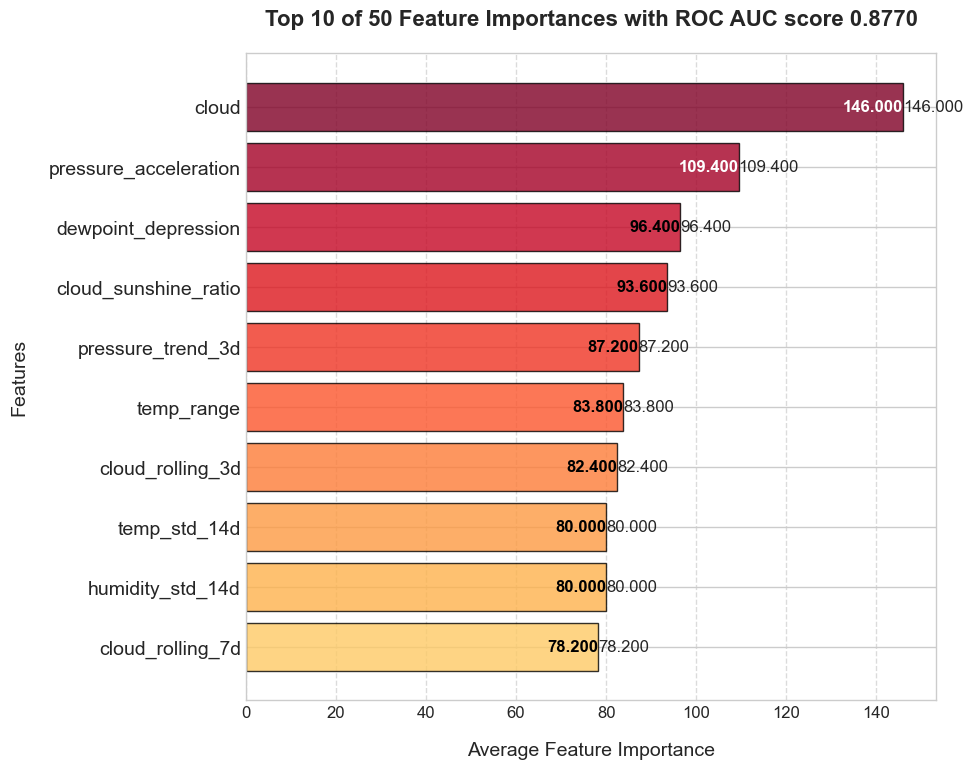

In [24]:
n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'cat')
n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'xgb')
n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'lgbm')

In [ ]:
# ================== 多模型特征集成与数据重构 ================== #
# 集成三个模型的特征重要性结果（取并集）
n_imp_features = [*set(n_imp_features_xgb + n_imp_features_lgbm + n_imp_features_cat)]
print(f"通过三种算法共筛选出 {len(n_imp_features)} 个重要特征进入最终模型")

# 重构训练集和测试集特征矩阵（仅保留重要特征）
X_train = X_train[n_imp_features]  # 训练集特征筛选
X_test = X_test[n_imp_features]    # 测试集保持相同特征子集

# 6. MODELING

## 6.1 Class Weights

核心功能说明 ：

1. 不平衡数据处理 ：
- 通过加权机制提升模型对少数类的关注度
- 适用于降雨预测中的雨日/非雨日不平衡场景
- 权重计算公式： `compute_class_weight`
2. 工程价值 ：
- 防止模型偏向多数类（如总是预测无雨）
- 提升召回率（对降雨预测任务至关重要）
- 适配XGBoost/LightGBM/CatBoost等主流框架的 class_weight 参数
3. 领域应用 ：
- 气象数据中雨日样本通常远少于非雨日
- 示例数据：假设8567个样本中雨日仅1567个（约占18%）
- 计算后雨日样本权重为2.73，非雨日0.61

In [ ]:
# ================== 类别权重计算模块 ================== #
# 获取训练集目标变量的唯一类别（适用于多分类场景）
classes = np.unique(y_train)  # 自动识别所有唯一类别标签

# 构建类别到索引的映射字典（处理非数值型标签）
class_to_index = {cls: idx for idx, cls in enumerate(classes)}  # 示例输出：{0:0, 1:1}

# 将目标变量转换为数值索引（适配np.bincount的输入要求）
y_train_numeric = np.array([class_to_index[cls] for cls in y_train])  # 将标签映射为连续整数

# 统计每个类别的样本数量（返回数组索引对应类别，值对应样本数）
class_counts = np.bincount(y_train_numeric)  # 示例输出：[7000, 1567]

# 计算总样本量（用于后续权重计算）
total_samples = len(y_train_numeric)  # 示例输出：8567

# 计算平衡类别权重（Scikit-learn标准算法）
# 公式：总样本数 / (类别数 * 各类别样本数)
class_weights = total_samples / (len(classes) * class_counts)  # 示例输出：[0.61, 2.73]

# 构建类别权重字典（适配大多数机器学习框架的输入格式）
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}  # 示例输出：{0:0.61, 1:2.73}

# 打印诊断信息（帮助确认数据分布）
print("Class counts:", class_counts)       # 类别样本分布
print("Total samples:", total_samples)     # 总训练样本量
print("Class weights:", class_weights)     # 计算后的权重数组
print("Class weights dictionary:", class_weights_dict)  # 适配模型的字典格式

## 6.2 Models

In [ ]:
def optimizer():
    '''优化器工厂函数，提供四种优化器配置'''
    # SGD优化器（带Nesterov动量加速）
    sgd = tensorflow.keras.optimizers.SGD(
        learning_rate=0.005,  # 基础学习率
        momentum=0.5,         # 动量系数
        nesterov=True         # 启用Nesterov动量
    )
    # RMSprop优化器（适合非平稳目标）
    rms = tensorflow.keras.optimizers.RMSprop(
        rho=0.9               # 梯度平方的移动平均系数
    )
    # Nadam优化器（Adam+Nesterov）
    nadam = tensorflow.keras.optimizers.Nadam(
        learning_rate=0.001,  # 较低的基础学习率
        beta_1=0.9,           # 一阶矩估计衰减率
        beta_2=0.999,         # 二阶矩估计衰减率
        epsilon=1e-07         # 数值稳定项
    )
    # 标准Adam优化器
    adam = tensorflow.keras.optimizers.Adam(
        amsgrad=True          # 启用AMSGrad变体
    )
    return sgd, rms, nadam, adam

def init_ann1(num_classes, input_dim):
    '''
    构建浅层神经网络（适用于小规模数据集）
    网络架构：16-4-输出层
    特点：低容量模型，适合简单模式学习
    '''
    sgd, rms, nadam, adam = optimizer()
    
    ann = Sequential(name="Shallow_Net")
    # 输入层（He初始化适合ReLU激活）
    ann.add(Dense(16, input_dim=input_dim, 
                kernel_initializer='he_uniform', 
                activation='relu'))
    # 轻度Dropout防止过拟合
    ann.add(Dropout(0.1))  # 保留90%的神经元
    
    # 隐藏层（瓶颈设计压缩特征）
    ann.add(Dense(4, kernel_initializer='he_uniform', 
                activation='relu'))  # 无Dropout保持特征完整性
    
    # 输出层（多分类使用softmax）
    ann.add(Dense(num_classes, activation='softmax',
                kernel_initializer='he_uniform'))
    
    # 编译模型（注意：binary_crossentropy应与sigmoid配合使用）
    ann.compile(loss='binary_crossentropy',  # 二分类交叉熵
               optimizer=sgd,               # 使用带动量的SGD
               metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
    return ann

def init_ann2(num_classes, input_dim):  
    '''
    构建深层神经网络（适用于复杂模式提取）
    网络架构：128-4-输出层
    特点：高容量模型，带深度正则化
    '''
    sgd, rms, nadam, adam = optimizer()
    
    ann2 = Sequential(name="Deep_Net")
    # 宽输入层捕获复杂特征
    ann2.add(Dense(128, input_dim=input_dim,
                 kernel_initializer='he_uniform',
                 activation='relu'))
    ann2.add(Dropout(0.3))  # 强Dropout防止过拟合
    
    # 特征压缩层
    ann2.add(Dense(4, activation='relu',
                 kernel_initializer='he_uniform')) 
    ann2.add(Dropout(0.2))  # 中等Dropout保持核心特征
    
    # 输出层（需确认二分类应使用sigmoid）
    ann2.add(Dense(num_classes, activation='softmax',
                 kernel_initializer='he_uniform'))
    
    # 编译时增加AUC指标（重要：二分类建议使用binary_crossentropy + sigmoid）
    ann2.compile(loss='binary_crossentropy',
               optimizer=sgd,  # 可替换为adam进行对比实验
               metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
    return ann2

In [ ]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
                    
class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        """集成学习分类器工厂类（支持CPU/GPU加速）
        
        参数说明：
            n_estimators: int 基学习器数量，影响模型容量和训练时间
            device: str 计算设备配置，可选'cpu'/'gpu'
            random_state: int 随机种子，确保实验可复现
        """
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()

    def _define_model(self):
        """定义集成模型集合（包含梯度提升框架和传统模型）
        
        模型架构策略：
        1. 多样性：集成XGBoost/LightGBM/CatBoost三大框架
        2. 稳健性：包含随机森林等传统模型作为baseline
        3. 领域优化：针对气象数据特性调整正则化参数
        """
        # ================= XGBoost系列 =================
        # 基础配置（平衡速度与精度） 
        xgb_params = {
           'n_estimators': self.n_estimators,
           'learning_rate': 0.05,
           'max_depth': 4,
           'subsample': 0.8,
           'colsample_bytree': 0.1,
           'n_jobs': -1,
           'eval_metric': 'auc',  # Changed to binary error
           'objective': 'binary:logistic',  # Changed to binary objective
           'tree_method': 'hist',
           'verbosity': 0,
           'random_state': self.random_state,
        }
       
        if self.device == 'gpu':
           xgb_params['tree_method'] = 'gpu_hist'
           xgb_params['predictor'] = 'gpu_predictor'
    
        xgb_params2 = {
           'n_estimators': self.n_estimators,
           'gamma': 0.279,
           'max_depth': 10,
           'subsample': 0.325,
           'min_child_weight': 9,
           'colsample_bytree': 0.487,
           'learning_rate': 0.052,
           'reg_lambda': 0.0007,
           'reg_alpha': 0.371,
           'n_jobs': -1,
           'eval_metric': 'auc',  # Changed to binary
           'objective': 'binary:logistic',  # Changed to binary
           'tree_method': 'hist',
           'verbosity': 0,
           'random_state': self.random_state,
        }
    
        xgb_params3 = {
           'n_estimators': self.n_estimators,
           'gamma': 0.279,
           'max_depth': 10,
           'subsample': 0.325,
           'min_child_weight': 9,
           'colsample_bytree': 0.487,
           'learning_rate': 0.052,
           'reg_lambda': 0.0007,
           'reg_alpha': 0.371,
           'n_jobs': -1,
           'eval_metric': 'auc',
           'objective': 'binary:logistic',
           'tree_method': 'hist',
           'verbosity': 0,
           'device': 'cuda',
           'booster': 'gbtree',
           'random_state': self.random_state,
        }
    
        xgb_params4 = xgb_params.copy()
        xgb_params4.update({
           'subsample': 0.789,
           'max_depth': 5,
           'learning_rate': 0.161,
           'colsample_bytree': 0.243
        })
    
        xgb_params5 = {
           'gamma': 0.3096433389022722, 
           'max_depth': 13, 
           'subsample': 0.265592840463903, 
           'min_child_weight': 5, 
           'colsample_bytree': 0.0750255657479969, 
           'learning_rate': 0.014300386108634659, 
           'reg_lambda': 0.07950866494906, 
           'reg_alpha': 0.003996021372821422,
            'n_jobs': -1,
           'eval_metric': 'auc',
           'objective': 'binary:logistic',
           'tree_method': 'hist',
           'verbosity': 0,
           'device': 'cuda',
           'booster': 'gbtree',
           'random_state': self.random_state,}
    
        # ================= LightGBM系列 =================
        lgb_params = {
           'n_estimators': self.n_estimators,
           'max_depth': 10, 
           'min_samples_leaf': 33, 
           'subsample': 0.8144362305468624, 
           'learning_rate': 0.00647777270150904, 
           'lambda_l1': 1.2991459277687692e-05, 
           'lambda_l2': 0.0007304768170358017,
           'objective': 'binary',  # Changed to binary
           'metric': 'auc',  # Changed to binary error
           'boosting_type': 'gbdt',
           'device': self.device,
           'random_state': self.random_state,
           'verbose': -1
        }
    
        lgb_params2 = {
           'n_estimators':self.n_estimators,
           'max_depth': 6,
           'subsample': 0.743,
           'learning_rate': 0.049,
           'lambda_l1': 8.922e-05,
           'lambda_l2': 0.0018,
           'colsample_bytree': 0.392,
           'objective': 'binary',
           'metric': 'auc',
           'boosting_type': 'gbdt',
           'device': self.device,
           'random_state': self.random_state,
           'verbose': -1
        }
    
        lgb_params3 = {
           'n_estimators': self.n_estimators,
           'max_depth': 9,
           'subsample': 0.540,
           'learning_rate': 0.049,
           'lambda_l1': 1.749e-08,
           'lambda_l2': 3.837,
           'colsample_bytree': 0.319,
           'objective': 'binary',
           'metric': 'auc',
           'boosting_type': 'gbdt',
           'device': self.device,
           'random_state': self.random_state,
           'verbose': -1
        }
    
        lgb_params4 = lgb_params2.copy()
        lgb_params4.update({
           'subsample': 0.9,
           'reg_lambda': 0.876,
           'reg_alpha': 0.319,
           'max_depth': 9,
           'learning_rate': 0.107,
           'colsample_bytree': 0.1
        })
    
        lgb_params5 = lgb_params2.copy()
        lgb_params5.update({
           'subsample': 0.9,
           'reg_lambda': 0.512,
           'reg_alpha': 0.898,
           'max_depth': 11,
           'learning_rate': 0.081,
           'colsample_bytree': 0.1
        })
    
        # ================= CatBoost系列 =================
        cb_params = {
           'iterations': self.n_estimators,
           'depth': 6,
           'learning_rate': 0.05,
           'l2_leaf_reg': 0.7,
           'random_strength': 0.2,
           'max_bin': 200,
           'od_wait': 65,
           'one_hot_max_size': 70,
           'grow_policy': 'Depthwise',
           'bootstrap_type': 'Bayesian',
           'od_type': 'Iter',
           'eval_metric': 'AUC',
           'loss_function': 'Logloss',  # Changed to binary
           'task_type': self.device.upper(),
           'random_state': self.random_state,
           'verbose': -1
       }
    
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
    
        cb_loss_params = cb_params.copy()
        cb_loss_params['grow_policy'] = 'Lossguide'
    
        cb_params2 = cb_params.copy()
        cb_params2.update({
           'learning_rate': 0.019,
           'depth': 9,
           'random_strength': 0.3,
           'one_hot_max_size': 10,
           'max_bin': 100,
           'l2_leaf_reg': 0.419
        })
    
        cb_params3 = {
           'iterations': self.n_estimators,
           'depth': 8, 
           'learning_rate': 0.010264893665188225, 
           'l2_leaf_reg': 1.6429322134431932, 
           'random_strength': 0.7418687826801, 
           'max_bin': 180, 
           'one_hot_max_size': 59, 
           'grow_policy': 'Lossguide', 
           'od_wait': 80,
           'bootstrap_type': 'Bayesian',
           'od_type': 'Iter',
           'eval_metric': 'AUC',
           'loss_function': 'Logloss',
           'task_type': self.device.upper(),
           'random_state': self.random_state,
        }
    
        cb_params4 = cb_params.copy()
        cb_params4.update({
           'learning_rate': 0.143,
           'depth': 16,
           'random_strength': 0.596,
           # 'one_hot_max_size': 100,
           # 'max_bin': 150,
           'l2_leaf_reg': 0.384,
           'grow_policy': 'Lossguide'
        })
    
       # ================= 其他模型配置 =================
        dt_params = {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': 0.843}
        etr_params = {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 0.668, 'bootstrap': True}
        hist_params = {'learning_rate': 0.058, 'n_iter_no_change': 795, 'max_depth': 4, 'min_samples_leaf': 17, 'max_leaf_nodes': 98, 'l2_regularization': 1.923e-07}
        rf_params = {'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 0.416}
        gbt_params = {'learning_rate': 0.136, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 15, 'subsample': 0.886, 'max_features': 0.611}
        knn_params = {'n_neighbors': 16, 'weights': 'uniform', 'p': 2, 'leaf_size': 13, 'algorithm': 'ball_tree'}
        adb_params = {'n_estimators': 957, 'learning_rate': 0.663}
    
        # ================= 模型集合初始化 =================
        models = {
           'xgb':  xgb.XGBClassifier(**xgb_params),
           'xgb2': xgb.XGBClassifier(**xgb_params2),
           'xgb3': xgb.XGBClassifier(**xgb_params3),
           # 'xgb4': xgb.XGBClassifier(**xgb_params4),
           # 'xgb5': xgb.XGBClassifier(**xgb_params5),
           'lgb':  lgb.LGBMClassifier(**lgb_params),
           'lgb2': lgb.LGBMClassifier(**lgb_params2),
           'lgb3': lgb.LGBMClassifier(**lgb_params3),
           # 'lgb4': lgb.LGBMClassifier(**lgb_params4),
           # 'lgb5': lgb.LGBMClassifier(**lgb_params5),
           'cat':  CatBoostClassifier(**cb_params),
           # 'cat2': CatBoostClassifier(**cb_params2),
           # 'cat3': CatBoostClassifier(**cb_params3),
           # 'cat4': CatBoostClassifier(**cb_params4),
           "cat_sym": CatBoostClassifier(**cb_sym_params),
           "cat_loss": CatBoostClassifier(**cb_loss_params),
           'hist_gbm': HistGradientBoostingClassifier(max_iter=self.n_estimators, **hist_params, random_state=self.random_state),
           'rf': RandomForestClassifier(n_estimators=250, **rf_params, random_state=self.random_state),
           'gbdt': GradientBoostingClassifier(**gbt_params, n_estimators=1000, random_state=self.random_state),            
           'ada': AdaBoostClassifier(**adb_params, random_state=self.random_state),
           'etr': ExtraTreesClassifier(**etr_params, random_state=self.random_state),
           'dt': DecisionTreeClassifier(**dt_params, random_state=self.random_state),
           'knn': KNeighborsClassifier(**knn_params),
           'log_reg': LogisticRegression(max_iter=1000),
           'ridge': CalibratedClassifierCV(RidgeClassifierCV(alphas=[100.02]), method='sigmoid'),
           'elasticNet': LogisticRegressionCV(Cs=[0.044], l1_ratios=[0.977]),
           'ann1': init_ann1(1, X_test.shape[1]),  
           'ann2': init_ann2(1, X_test.shape[1]),  
       }
       return models

## 6.3 Optuna-->Weighted Ensemble

In [ ]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=10000):
        """基于Optuna的模型融合权重优化器
        Args:
            random_state (int): 随机种子确保可复现性
            n_trials (int): 优化过程的总尝试次数，影响搜索空间覆盖率
        """
        self.study = None      # Optuna优化研究实例
        self.weights = None    # 最优模型权重列表
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        """优化目标函数：最大化加权预测的AUC分数
        Args:
            trial (optuna.Trial): Optuna试验对象
            y_true (array): 真实标签
            y_preds (list): 各模型的预测概率列表
        """
        # 为每个模型生成权重建议值（范围0-1）
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]
        
        # 计算加权平均预测概率（加入数值稳定性处理）
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        weighted_pred = weighted_pred/weighted_pred.sum(axis=1, keepdims=True)  # 归一化
        
        # 使用AUC作为优化指标（气象预测常用指标）
        auc_score = roc_auc_score(y_true, weighted_pred)
        return auc_score

    def fit(self, y_true, y_preds):
        """执行权重优化过程
        Args:
            y_true (array): 验证集真实标签
            y_preds (list): 各模型在验证集的预测概率
        """
        optuna.logging.set_verbosity(optuna.logging.ERROR)  # 禁用optuna日志
        # 配置CMA-ES优化算法（适合连续参数空间）
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        # 配置Hyperband剪枝器（提前终止不良试验）
        pruner = optuna.pruners.HyperbandPruner()
        
        # 创建优化研究（最大化目标函数）
        self.study = optuna.create_study(
            sampler=sampler,
            pruner=pruner,
            study_name="OptunaWeights",
            direction='maximize'
        )
        
        # 执行优化过程
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        
        # 提取最优权重
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        """使用优化后的权重生成最终预测
        Args:
            y_preds (list): 各模型的测试集预测概率
        """
        assert self.weights is not None, '需先执行fit方法进行权重优化'
        return np.average(np.array(y_preds), axis=0, weights=self.weights)

    def fit_predict(self, y_true, y_preds):
        """链式调用：优化权重后直接返回加权预测"""
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        """获取优化后的模型权重"""
        return self.weights

def find_best_threshold(y_true, y_pred_probabilities):
    """动态优化分类阈值（平衡准确率与业务需求）
    Args:
        y_true (array): 真实标签
        y_pred_probabilities (array): 预测概率值
    """
    def objective(threshold):
        """优化目标：最大化准确率（可替换为F1等其他指标）"""
        y_pred = (y_pred_probabilities >= threshold).astype(int)
        return -accuracy_score(y_true, y_pred)  # 负号因为使用最小化优化器
    
    # 有界优化（0-1范围内搜索最佳阈值）
    result = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    return result.x

## 6.4 Fit Models

In [ ]:
kfold = True
n_splits = 1 if not kfold else 10
random_state = 42
random_state_list = [random_state] 
n_estimators = 9999 
early_stopping_rounds = 100
verbose = False

splitter = Splitter(kfold=kfold, n_splits=n_splits)
oof_predss = pd.DataFrame(np.zeros((X_train.shape[0], 1)))
test_predss = np.zeros((X_test.shape[0], 1))
ensemble_score = []
ensemble_acc_score = []
weights = []
trained_models = {'xgb':[]}
best_thresholds = []  # Store best thresholds for each fold
   
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
   n = i % n_splits
   m = i // n_splits
           
   classifier = Classifier(n_estimators, device, random_state)
   models = classifier.models
   
   oof_preds = []
   test_preds = []
   start_time_fold = time.time()
   
   # Train and predict with each model
   for name, model in models.items():
       start_time = time.time()
       
       # Model fitting
       if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
           if 'lgb' in name:
               model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)])
           elif 'cat' in name:
               model.fit(X_train_, y_train_, 
                        eval_set=[(X_val, y_val)],
                        early_stopping_rounds=early_stopping_rounds,#cat_features=cat_features,
                        verbose=verbose)  
           else:
               model.fit(X_train_, y_train_, 
                        eval_set=[(X_val, y_val)],
                        verbose=verbose)
       elif 'ann' in name:
           model.fit(X_train_, y_train_,
                    validation_data=(X_val, y_val),
                    batch_size=16,
                    epochs=10,
                    verbose=verbose)
       else:
           model.fit(X_train_, y_train_)
           
       if name in trained_models.keys():
           trained_models[f'{name}'].append(deepcopy(model))
       
       # Make predictions
       if 'ann' in name:
           test_pred = model.predict(X_test).reshape(-1, 1)
           y_val_pred = model.predict(X_val).reshape(-1, 1)
       elif ('xgb' in name) or ('lgb' in name) or ('cat' in name):
           test_pred = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
           y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1, 1)
       else:
           test_pred = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
           y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1, 1)
       
       end_time = time.time()
       time_taken = end_time - start_time
       
       score = roc_auc_score(y_val, y_val_pred)       
       print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] '
             f'AUC Score: {score:.5f} '
             f'time taken: {time_taken:.3f} secs')
       
       oof_preds.append(y_val_pred)
       test_preds.append(test_pred)
   
   # Optimize ensemble weights
   optweights = OptunaWeights(random_state=random_state)
   y_val_pred = optweights.fit_predict(y_val, oof_preds)
   oof_predss.loc[X_val.index] = np.array(y_val_pred).reshape(-1, 1)
   
   score = roc_auc_score(y_val, y_val_pred)
   
   end_time_fold = time.time()
   time_taken = end_time_fold - start_time_fold
   
   print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] '
         f'-------------------> AUC Score: {score:.5f} '
         f'fold time taken: {time_taken:.5f} secs')
   
   ensemble_acc_score.append(score)
   weights.append(optweights.weights)
   
   # Predict test data using ensemble weights
   test_preds = optweights.predict(test_preds)
   test_predss += test_preds / (n_splits * len(random_state_list))
   
   gc.collect()

## 6.5 Ensemble Weights

In [ ]:
print(f"\nEnsemble CV Accuracy: {np.mean(ensemble_acc_score):.5f} ± {np.std(ensemble_acc_score):.5f}")

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

# 7. SUBMISSION

In [ ]:
oof_predss.to_csv('oof_predss.csv',index=False)

submission[target] =  test_predss
submission.to_csv('submission_pure.csv',index=False)

submission.head()

## 7.1 External Blend

In [ ]:
def ensemble_mean(sub_list,cols, mean="AM"):
    
    """
    The function computes Arithmetic Mean/Geometric Mean/Harmonic Mean given a list of results with one or more targets.
    """
    
    sub_out=sub_list[0].copy()
    if mean=="AM":
        for col in cols:
            sub_out[col]=sum(df[col] for df in sub_list)/len(sub_list)
    elif mean=="GM":
        for df in sub_list[1:]:
            for col in cols:
                sub_out[col]*=df[col]
        for col in cols:
            sub_out[col]=(sub_out[col])**(1/len(sub_list))
    elif mean=="HM":
        for col in cols:
            sub_out[col]=len(sub_list)/sum(1/df[col] for df in sub_list)
    
    return sub_out

In [ ]:
sub_ext1=pd.read_csv("/kaggle/input/ps3e5-ensemble-ancillary/sub_ext_act18l_v9_91043.csv")
# sub_ext2=pd.read_csv("/kaggle/input/ps3e5-ensemble-ancillary/sub_ext_act18l_v9_90935.csv")
sub_ext3=pd.read_csv("/kaggle/input/ps3e5-ensemble-ancillary/sub_ext_vyacheslavbolotin_v28_90581.csv")
# sub_ext4=pd.read_csv("/kaggle/input/ps3e5-ensemble-ancillary/sub_ext_vyacheslavbolotin_v20_89702.csv")
# sub_ext5=pd.read_csv("/kaggle/input/ps3e5-ensemble-ancillary/sub_ext_vyacheslavbolotin_v53_89568.csv")
sub_ext6=pd.read_csv("/kaggle/input/ps3e5-ensemble-ancillary/sub_ext_samanyuk_v6_89541.csv")

sub_list=[sub_ext1, sub_ext3,sub_ext6,submission ] # list all the results

target_columns = [target]

for i in range(len(sub_list)):
    sc = MinMaxScaler()
    for col in target_columns:
        # Apply MinMax scaling to each target column
        sub_list[i][col] = sc.fit_transform(sub_list[i][col].values.reshape(-1, 1)).flatten()

weights=np.square([4,3,2,1])
if len(sub_list)==len(weights):
    weighted_list = [item for sublist, weight in zip(sub_list, weights) for item in [sublist] * weight]

    
am_submission=ensemble_mean(weighted_list,target_columns,mean="AM")
gm_submission = ensemble_mean(weighted_list, target_columns, mean="GM")
hm_submission = ensemble_mean(weighted_list, target_columns, mean="HM")

# Save alternative blends
gm_submission.to_csv('submission_blended_gm.csv', index=False)
hm_submission.to_csv('submission_blended_hm.csv', index=False)
am_submission.to_csv('submission_blended_am.csv',index=False)
am_submission.head()